In [2]:
import seaborn as sns
import numpy as np

from scipy.stats import kurtosis, skew, gaussian_kde
from scipy.signal import argrelextrema

from rcv_distribution import *
from rcv_dimensionality import *

In [3]:
import numpy as np
from scipy.stats import rankdata

def compute_ecdf(data):
    """Compute the empirical cumulative distribution function (ECDF) of data."""
    sorted_data = np.sort(data)
    n = len(data)
    return sorted_data, np.arange(1, n+1) / n

def dip_statistic(data):
    """Compute Hartigan's dip statistic for data."""
    data = np.sort(data)
    n = len(data)
    
    # Compute the empirical CDF
    x, ecdf = compute_ecdf(data)
    
    # Compute the greatest difference on the left and right side for each data point
    U = np.arange(1, n+1) / n
    D = U - np.arange(0, n) / n
    
    # Calculate the difference between the empirical distribution function and the 
    # unimodal distribution function that minimizes that maximum difference.
    low_dip = (ecdf - D).clip(min=0)
    up_dip = (U - ecdf).clip(min=0)
    both_dips = np.column_stack((low_dip, up_dip))
    
    # The dip statistic is the maximum difference over all data points
    dip = np.max(both_dips)
    
    return dip

/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_learning/rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Normalized distances: {'Palin, Sarah': 0.0, 'Begich, Nick': 0.8631380122400529, 'Bye, Chris': 2.053386546747744, 'Peltola, Mary S.': 3.0}


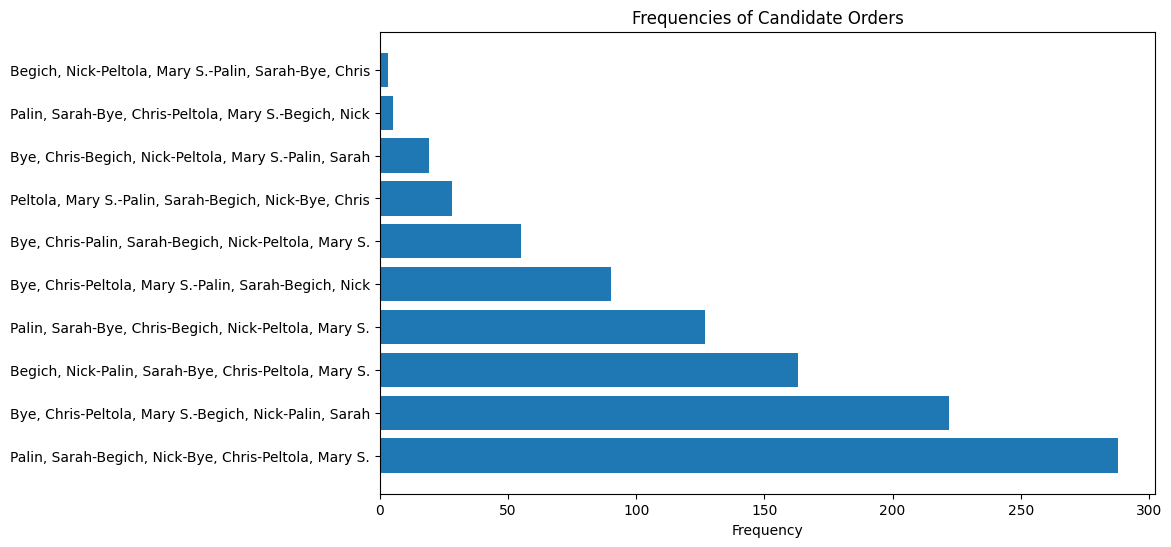

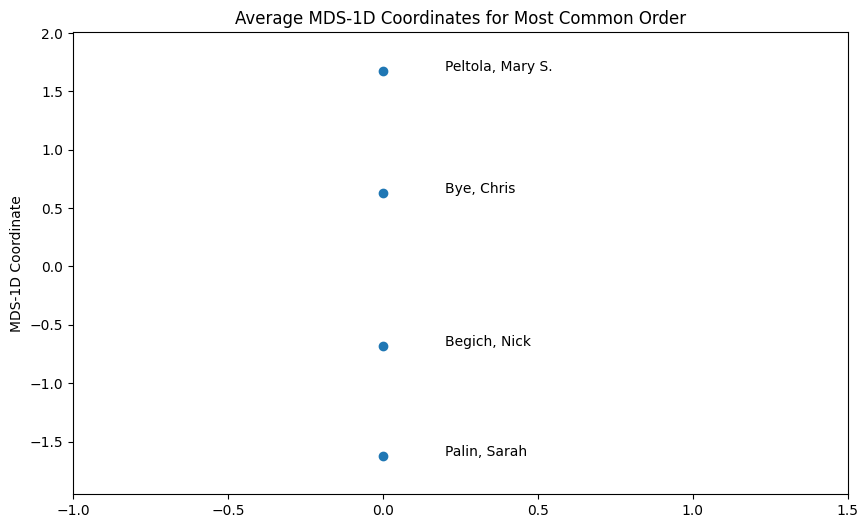

/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_learning/rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Consistency points: {3.0: 54315, 0.0: 21392, 0.36456556987347455: 5421, 0.21578450306001307: 27631, 1.3973535091800393: 2487, 0.8631380122400523: 12355, 1.1607001458669752: 1207, 0.42372891070174057: 4292, 2.053386546747744: 927, 1.1863617685719654: 995, 2.290039910060808: 334, 0.513346636686936: 1019, 1.0528078943369688: 1649, 0.75: 1006, 2.1412588432473467: 183, 1.2790268275235073: 401, 0.631673318343468: 165, 2.087312717482343: 344, 2.03336659171734: 50}
Ashman's D statistic: 3.537250192726943
Sarle's coefficient: 0.879564821167359
Hartigan's Dip Statistic: 0.9999926564003143


In [4]:
# Test the function with a custom CSV file
csv = "../rcv_elections_database/single/Alaska_11082022_USRepresentative.csv"

# Perform the RCV analysis
test = perform_rcv_analysis(csv, n_runs=1000)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = test

# Print the normalized distances between candidates and plot the MDS analysis
print("Normalized distances:", get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names))
plot_rcv_analysis(mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names)

# Get the consistency points for the bimodality analysis
points = get_consistency_points(csv)
print("Consistency points:", points)

# Create a list of data points
data_points = []
for key, value in points.items():
    data_points.extend([key] * value)

# Convert to numpy array
data_points = np.array(data_points)

# Calculate skewness and kurtosis
g = skew(data_points)
k = kurtosis(data_points)

# Calculate KDE without plotting
density = gaussian_kde(data_points)
x_vals = np.linspace(min(data_points), max(data_points), 1000)
y_vals = density(x_vals)

# Identify local maxima in the KDE
maxima_indices = argrelextrema(y_vals, np.greater)

# Get the x-values of the maxima
modes = x_vals[maxima_indices]

# Check if there are at least two modes
if len(modes) >= 2:
    mode1, mode2 = modes[:2]
else:
    mode1, mode2 = None, None

# Split the data into two groups based on proximity to the modes
data_group1 = [point for point in data_points if abs(point - mode1) < abs(point - mode2)]
data_group2 = [point for point in data_points if abs(point - mode1) > abs(point - mode2)]

# Calculate mean and variance for each group
mu1, sigma1_sq = np.mean(data_group1), np.var(data_group1)
mu2, sigma2_sq = np.mean(data_group2), np.var(data_group2)

# Calculate Ashman's D statistic (D > 2)
ashmans_D = abs(mu1 - mu2) / np.sqrt((sigma1_sq + sigma2_sq) / 2)
print("Ashman's D statistic:", ashmans_D)

# Calculate Sarle's bimodality coefficient b (b > 5/9)
n = len(data_points)
sarle = (g**2 + 1) / (k + 3 * (n-1)**2 / ((n-2) * (n-3)))
print("Sarle's coefficient:", sarle)

# Calculate Hartigan's dip statistic ... (TODO - Permutation test)
hartigan_dip = dip_statistic(data_points)
print("Hartigan's Dip Statistic:", hartigan_dip)


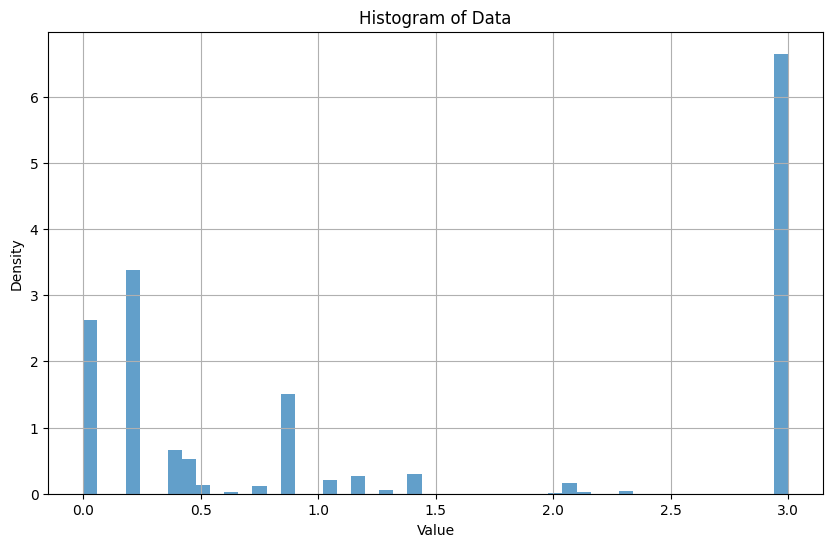

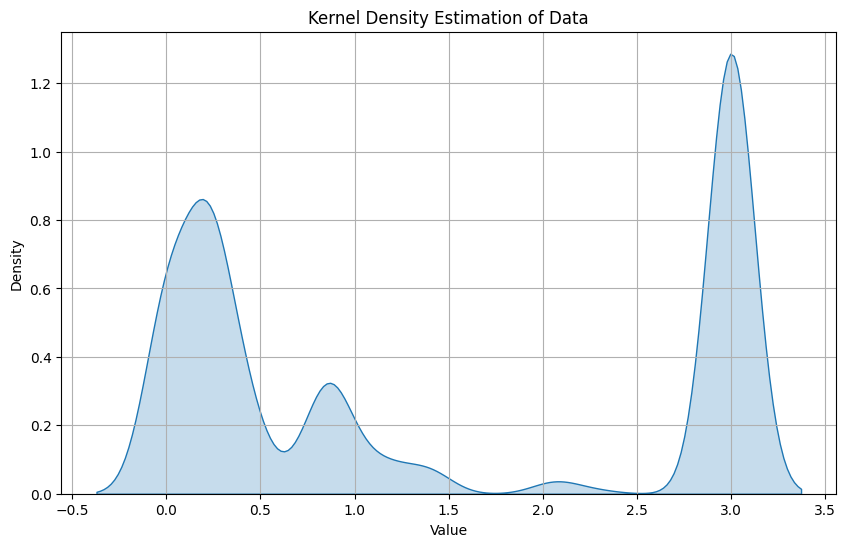

In [5]:
# Prepare data for histogram
data_list = [x for x, count in points.items() for _ in range(count)]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(data_list, bins=50, density=True, alpha=0.7)
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot kernal density estimation
plt.figure(figsize=(10, 6))
sns.kdeplot(data_list, fill=True)
plt.title('Kernel Density Estimation of Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()